# Stock price modelling for the mathematically curious

In this notebook we discuss a mathematical model for stock prices. We present some numerical approximations and illustrate these with simple plots.

### Bank balance as an Ordinary Differential Equation

Consider the general ordinary differential equation for unknown $U : (0,\infty) \to \mathbb{R}$,

$$
\tag{ODE}
\frac{dU(t)}{dt} = f(t,U(t)), \quad t > 0,
$$

with a given initial value $U(0) = U_0$ and function $f : (0,\infty) \times \mathbb{R} \to \mathbb{R}$.

By integrating, we see that it is equivalent with the integral equation

$$
\tag{IE}
U(t) = U_0 + \int_0^t f(s,U(s)) \, ds , \quad t > 0.
$$

For example, we could be modelling our bank account balance $B$ by

$$
\frac{dB(t)}{dt} = \mu B(t) + F(t), \quad t > 0,
$$

where $\mu$ is the interest rate and $F$ stands for, say, your salary or expenses.

It is easy to see that the solution to this equation is given by

$$
B(t) = e^{\mu t}B_0 + \int_0^t e^{\mu (t-s)} F(s) \, ds , \quad t > 0,
$$

where $B_0$ is the initial balance.


In [103]:
# We inspect our model over a time frame

import pandas as pd
import numpy as np

start_date = '2017-01-01'
end_date = '2017-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

# We assume that the daily earnings and expenses vary somewhat randomly
daily_earnings_avg = 10.0  # average daily earnings
daily_expenses_scale = 50.0  # scale of unexpected expenses
F_df = pd.DataFrame(data=np.random.normal(loc=daily_earnings_avg, 
                                          scale=daily_expenses_scale, 
                                          size=len(date_range)), 
                    index=date_range)

def F(s):
    return F_df.loc[s].values

B_0 = 10000
mu = 0.01 / 365  # 1 percent annual interest rate transformed into daily interest rate

def integrand(t,s):
    return np.exp(mu * (t - s).days) * F(s)

def integral(t):
    return sum([integrand(t,s) for s in pd.date_range(start=start_date, end=t)])

def B(t):
    return np.exp(mu * (t - pd.to_datetime(start_date)).days) * B_0 + integral(t)

bank_balance = pd.DataFrame(data=[np.round(B(t),2) for t in date_range], index=date_range, columns=['bank_balance'])

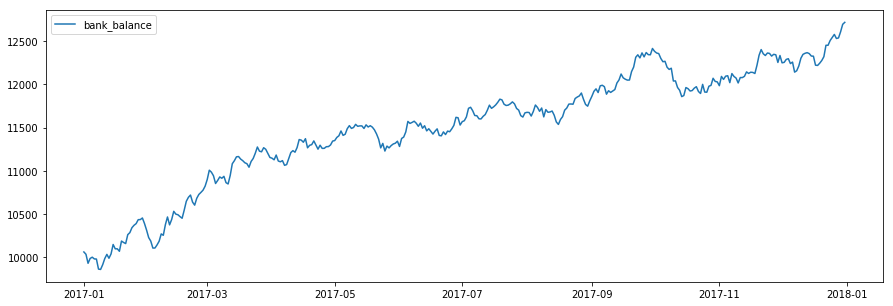

In [104]:
# We plot the bank balance over our chosen time frame

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))
sns.lineplot(data=bank_balance)

### Fluctuations as a standard Wiener process

What if we wanted to invest in some stocks intead? It is generally agreed that stock values fluctuate quite randomly. We could therefore try to model the stock price $S_t$ at time $t$ by

$$
\tag{1}
\frac{dS_t}{dt} = \mu S_t + \sigma S_t \xi_t , \quad t > 0,
$$

where $\mu$ and $\sigma$ stand for expected return and volatility, respectively, and $\xi_t$ denotes random "noise".

It is not immediately clear how random noise should be desrcibed mathematically. The generally accepted way is to view it formally as a time derivative of a standard Wiener process $W$, that is

$$
\xi_t = \frac{dW_t}{dt} .
$$

By definition, the standard Wiener process
- has continuous paths, 
- $W_0 = 0$ almost surely,
- has independent increments so that $W_t - W_s$ is independent from $W_u - W_v$ whenever $t > s > u > v$,
- $W_t - W_s$ is normally distributed with mean $0$ and variance $t-s$, whenever $t > s$

The last property has the effect that the displacement of Wiener process scales, not linearly with time, but with its square root, that is

$$
dW_t \sim (dt)^{1/2}.
$$

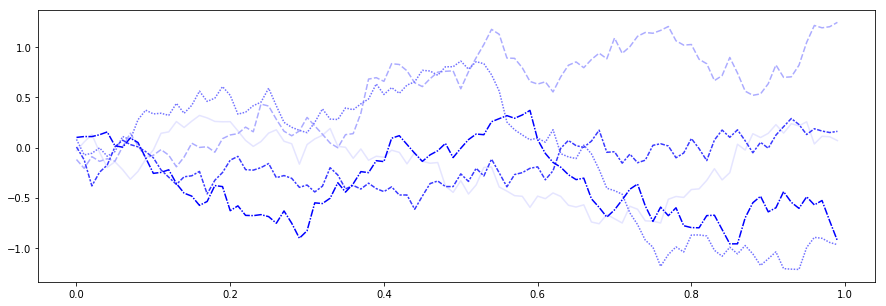

In [33]:
# Here we plot a few sample paths of a discretized Wiener process over (0,1)

N = 100
K = 5

dt = 1 / N
dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(N,K))
W = np.cumsum(dW, axis=0)

W_df = pd.DataFrame(data=W, index=np.array(range(100)) / N)

plt.figure(figsize=(15,5))

sns.lineplot(data=W_df, 
             palette=sns.light_palette("blue", n_colors=K), 
             legend=False)

### Stock Price as a Stochastic Differential Equation

Proceeding formally, we may then multiply both sides of equation (1) by $dt$ and arrive at

$$
\tag{SDE}
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t, \quad t > 0,
$$

which can be interpreted rigorously as the integral equation

$$
S_t = S_0 + \mu \int_0^t S_s \, ds + \sigma \int_0^t S_s \, dW_s , \quad t > 0.
$$

The problem is then reduced to defining what we mean by the integral

$$
\int_0^t S_s \, dW_s .
$$

Recall that the usual Riemann integral can be viewed as the limit of approximating sums as

$$
\int_0^t f(s) \, ds \sim \sum_{k=0}^N f(s_k)(s_{k+1} - s_k) ,
$$

given a partition $0 = s_0 < \cdots < s_k < s_{k+1} < \cdots < s_N = t$.

We define the stochastic integral of a deterministic function similarly:

$$
\int_0^t f(s) \, dW_s \sim \sum_{k=0}^N f(s_k)(W_{s_{k+1}} - W_{s_k})
$$

This definition can be extended to suitable stochastic processes such as our random stock price.

### Itô formula

Recall the Taylor expansion of a smooth function $f$ around $(t',x')$:

$$
f(t,x) - f(t',x') = \frac{\partial f}{\partial t} (t',x') (t-t') + \frac{\partial f}{\partial x} (t',x') (x-x')
+ \frac{1}{2} \frac{\partial^2 f}{\partial t^2} (t',x') (t-t')^2
+ \frac{1}{2} \frac{\partial^2 f}{\partial x^2} (t',x') (x-x')^2 + \cdots
$$

As $(t,x)$ approaches $(t',x')$ we arrive at the first order approximation

$$
df(t,x) = \frac{\partial f}{\partial t} (t,x) \, dt + \frac{\partial f}{\partial x}(t,x) \, dx
$$

A stochastic version of this arises from substituting $W_t$ for $x$. Now, since $dW_t \sim (dt)^{1/2}$, also the second order terms contribute to the first order approximation:,

$$
\frac{1}{2} \frac{\partial^2 f}{\partial t^2} (t,W_t) \, dt^2
+ \frac{1}{2} \frac{\partial^2 f}{\partial x^2} (t,W_t) \, dW_t^2
\sim \frac{1}{2} \frac{\partial^2 f}{\partial x^2} (t,W_t) \, dt .
$$

This leads us to Itô formula:

$$
df(t,W_t) = \frac{\partial f}{\partial t}(t,W_t) \, dt + \frac{\partial f}{\partial x} (t,W_t) \, dW_t + \frac{1}{2} \frac{\partial^2 f}{\partial x^2} (t,W_t) \, dt
$$

### Solution to our SDE

We are now ready to face the SDE modelling our stock prices. Indeed, let us use the Itô formula to compute the differential of

$$
S_t = e^{W_t} .
$$

Without difficulty, we see that

$$
de^{W_t} = e^{W_t} \, dW_t + \frac{1}{2} e^{W_t} \, dt
$$

so that we've arrived to the solution of

$$
dS_t = \frac{1}{2} S_t \, dt + S_t \, dW_t .
$$

This is a special case of our equation with

$$
\begin{cases}
\mu = 1/2, \\ \sigma = 1.
\end{cases}
$$

With some thought, we notice that the general case is solved by

$$
S_t = \exp((\mu - \sigma^2 / 2)t + \sigma W_t) .
$$

This process is known as Geometric Brownian motion.

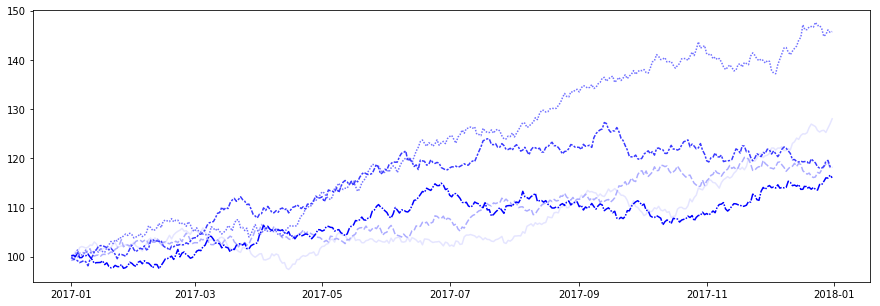

In [146]:
# plot S_t

N = len(date_range)
K = 5

dt = 1 / N
dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(N,K))

W_df = pd.DataFrame(data=np.cumsum(dW, axis=0), index=date_range)

def W(t):
    return W_df.loc[t]

S_0 = 100
sigma = 0.1
mu = 0.0055

def S(t, mu, sigma, W):
    return S_0 * np.exp((mu - sigma**2 / 2) * (t - pd.to_datetime(start_date)).days + sigma * W(t))

stock_price = pd.DataFrame(data=[np.round(S(t, mu, sigma, W),2) for t in date_range], 
                           index=date_range)

plt.figure(figsize=(15,5))

sns.lineplot(data=stock_price, 
             palette=sns.light_palette("blue", n_colors=K), 
             legend=False)